# GroupLiNGAM

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_prior_knowledge, make_dot

import warnings
warnings.filterwarnings('ignore')

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)

['1.26.4', '2.2.3', '0.20.3', '1.11.0']


## Test data
First, we generate a causal structure with 5 variables. Then we create a dataset with 5 variables from x0 to x4.

These variables are grouped as follows:
- Group 1: x0, x1
- Group 2: x2, x3
- Group 3: x4

In [2]:
np.random.seed(100)
n_samples=1000

def get_external_effect(n_samples):
    zi = np.random.normal(0, 1, n_samples)
    qi = np.random.choice(np.concatenate((np.random.uniform(0.5, 0.8, n_samples//2),
                                          np.random.uniform(1.2, 2.0, n_samples//2))))
    ei = np.sign(zi) * np.abs(zi) ** qi
    ei = (ei - np.mean(ei)) / np.std(ei)
    return ei

x0 = get_external_effect(n_samples)
x1 = get_external_effect(n_samples)
x2 = -1.21 * x1 + get_external_effect(n_samples)
x3 = -1.98 * x0 + get_external_effect(n_samples)
x4 = -0.55 * x1 - 0.50 * x2 - 1.16 * x3 + get_external_effect(n_samples)

# データフレームにまとめる
X = pd.DataFrame(np.array([x0, x1, x2, x3, x4]).T, columns=['x0', 'x1', 'x2', 'x3', 'x4'])

X.head()

,x0,x1,x2,x3,x4
0,-1.608789,1.230028,-1.516625,3.914554,-6.042585
1,0.078166,-0.040099,0.073176,-0.454598,0.860043
2,0.741542,-0.228636,0.024761,-1.807335,3.379655
3,-0.043394,0.002091,0.499962,0.709751,-1.574337
4,0.549565,-0.352250,2.541741,-0.000427,-1.948394


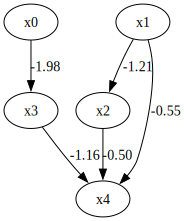

In [3]:
m = np.array([[   0.0,   0.0,   0.0,   0.0, 0.0],
              [   0.0,   0.0,   0.0,   0.0, 0.0],
              [   0.0, -1.21,   0.0,   0.0, 0.0],
              [ -1.98,   0.0,   0.0,   0.0, 0.0],
              [   0.0, -0.55, -0.50, -1.16, 0.0]])

dot = make_dot(m, labels=['x0', 'x1', 'x2', 'x3', 'x4'])

# Save pdf
dot.render('dag')

# Save png
dot.format = 'png'
dot.render('dag')

dot

## Causal Discovery
To run causal discovery, we create a `GroupLiNGAM` object and call the `fit` method.

In [4]:
model = lingam.GroupLiNGAM()
model.fit(X)

Using the `causal_order_` properties, we can see the causal order of the variables by group as a result of the causal discovery.

In [5]:
model.causal_order_

[[0], [1], [2], [3], [4]]

Also, using the `adjacency_matrix_` properties, we can see the adjacency matrix as a result of the causal discovery. The coefficients between variables estimated with the same group are np.nan.

In [6]:
model.adjacency_matrix_

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -1.189,  0.   ,  0.   ,  0.   ],
       [-1.968,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.566, -0.494, -1.155,  0.   ]])

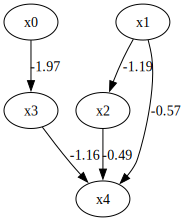

In [7]:
make_dot(model.adjacency_matrix_)

## Bootstrapping

We call `bootstrap()` method instead of `fit()`. Here, the third argument specifies the number of bootstrap sampling.

In [ ]:
model = lingam.GroupLiNGAM()
result = model.bootstrap(X, 100)

## Causal Directions

Since `BootstrapResult` object is returned, we can get the ranking of the causal directions extracted by `get_causal_direction_counts()` method. In the following sample code, `n_directions` option is limited to the causal directions of the top 8 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.01 or more.

In [ ]:
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [ ]:
print_causal_directions(cdc, 100)

## Directed Acyclic Graphs

Also, using the `get_directed_acyclic_graph_counts()` method, we can get the ranking of the DAGs extracted. In the following sample code, `n_dags` option is limited to the dags of the top 3 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.01 or more.

In [ ]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [ ]:
print_dagc(dagc, 100)

## Probability
Using the `get_probabilities()` method, we can get the probability of bootstrapping.

In [ ]:
prob = result.get_probabilities(min_causal_effect=0.01)
print(prob)

## Total Causal Effects
Using the `get_total_causal_effects()` method, we can get the list of total causal effect. The total causal effects we can get are dictionary type variable. We can display the list nicely by assigning it to pandas.DataFrame. Also, we have replaced the variable index with a label below.

In [ ]:
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

# Assign to pandas.DataFrame for pretty display
df = pd.DataFrame(causal_effects)
labels = [f'x{i}' for i in range(X.shape[1])]
df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
df

We can easily perform sorting operations with pandas.DataFrame.

In [ ]:
df.sort_values('effect', ascending=False).head()

In [ ]:
df.sort_values('probability', ascending=True).head()

Because it holds the raw data of the total causal effect (the original data for calculating the median), it is possible to draw a histogram of the values of the causal effect, as shown below.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from_index = 0 # index of x0
to_index = 4 # index of x4
plt.hist(result.total_effects_[:, to_index, from_index])

## Bootstrap Probability of Path
Using the `get_paths()` method, we can explore all paths from any variable to any variable and calculate the bootstrap probability for each path. The path will be output as an array of variable indices. For example, the array `[3, 0, 1]` shows the path from variable X3 through variable X0 to variable X1.

In [ ]:
from_index = 0 # index of x0
to_index = 4 # index of x4

pd.DataFrame(result.get_paths(from_index, to_index))